# CLIP GRADCAM

Derived from https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_GradCAM_Visualization.ipynb

In [37]:
# %%capture
# %pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
# %pip install git+https://github.com/openai/CLIP.git

In [38]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path
from src.pipeline.helper import get_all_samples
from src.utils.clip_grad_cam import *

import seaborn as sns
from sklearn.metrics import confusion_matrix


In [39]:
clip_model = "ViT-B/16" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/14", "ViT-B/16", "ViT-B/32"]


blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

In [110]:
confusion_matrix = np.zeros((7, 19))
conf = confusion_matrix[0]

saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]

classes = ['dress', 'jacket', 'shirt', 'tshirt', 'pant', 'short']

classes_prompt = [f'a photo of a {cl}' for cl in classes]

for k, cloth_class in enumerate(classes):

    search_index = k

    all_samples = get_all_samples(cloth_class)

    all_samples = all_samples[:20]

    for sample in all_samples:
        
        image = Image.open(sample[1])
        
        for i in range (0, 19):

            rot_image = image.rotate(10*i)

            image_input = preprocess(rot_image).unsqueeze(0).to(device)
            image_np = load_image(rot_image, model.visual.input_resolution)

            text = clip.tokenize(classes_prompt).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image_input)
                text_features = model.encode_text(text)

            # Pick the top 5 most similar labels for the image
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(6)

            # Update confusion matrix
            for value, index in zip(values, indices):
                    if index.item() == k:
                        confusion_matrix[k][i] += 1
                    break  # Break to count only the first match

# Print or further process the confusion matrix if needed
print(confusion_matrix)


[[17. 16. 17. 15. 13. 11. 10. 10.  8.  7.  7.  6.  6.  3.  1.  3.  0.  0.
   0.]
 [20. 20. 20. 19. 19. 18. 19. 18. 19. 20. 18. 18. 18. 16. 14. 14.  9. 10.
   0.]
 [18. 18. 18. 19. 14. 12. 14.  9. 12. 13. 12. 12. 14. 10.  7.  5. 10.  4.
   0.]
 [17. 16. 14. 10. 12.  6.  6.  5.  5.  5.  5.  5.  5.  5.  5.  3.  5.  3.
   0.]
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 19. 20. 20. 20. 20. 20. 20. 20. 20.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.]]


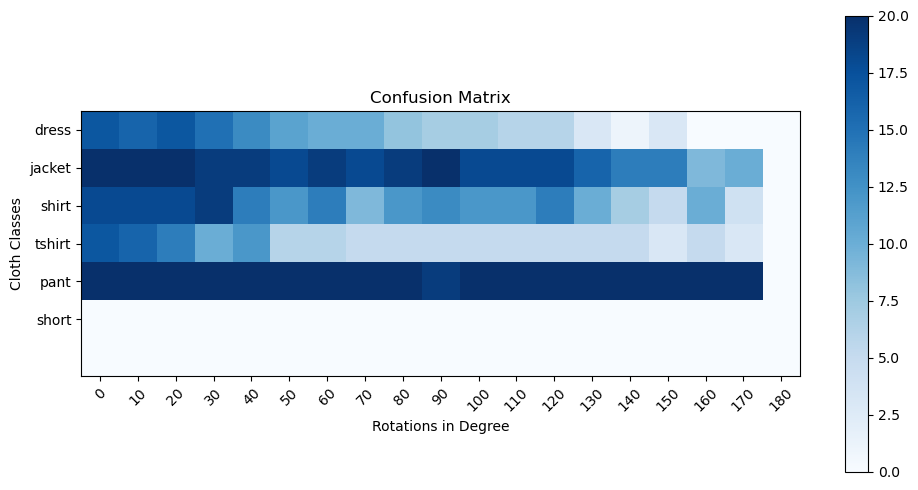

In [111]:
rotations = [i for i in np.arange(0, 190, 10)]
# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 5))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(rotations)), rotations, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('Cloth Classes')
plt.xlabel('Rotations in Degree')
plt.tight_layout()
plt.show()

In [98]:
# Initialize confusion matrix
confusion_matrix = np.zeros((6, 6))

# Define the saliency layer
saliency_layer = "layer4"  # @param ["layer4", "layer3", "layer2", "layer1"]

# Define classes
classes = ['dress', 'jacket', 'shirt', 'tshirt', 'pant', 'short']
classes_prompt = [f'a photo of a {cl}' for cl in classes]

# Iterate through each class
for k, cloth_class in enumerate(classes):

    # Get all samples for the current class
    all_samples = get_all_samples(cloth_class)
    all_samples = all_samples[:20]

    for sample in all_samples:
        image = Image.open(sample[1])

        for i in range(18):  # Rotating the image
            rot_image = image.rotate(10 * i)

            # Preprocess the rotated image
            image_input = preprocess(rot_image).unsqueeze(0).to(device)
            image_np = load_image(rot_image, model.visual.input_resolution)

            # Tokenize the text
            text = clip.tokenize(classes_prompt).to(device)

            with torch.no_grad():
                # Encode image and text features
                image_features = model.encode_image(image_input)
                text_features = model.encode_text(text)

            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
            # Compute similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarity[0].topk(6)

            # Update confusion matrix
            for value, index in zip(values, indices):
                    confusion_matrix[k][index.item()] += 1
                    break  # Break to count only the first match

# Print or further process the confusion matrix if needed
print(confusion_matrix)


[[150.  10.  36.   2. 151.  11.]
 [  2. 309.  10.   0.  39.   0.]
 [  2.  52. 221.   0.  85.   0.]
 [  0.  16. 145. 132.  67.   0.]
 [  0.   1.   0.   0. 359.   0.]
 [  0.  11.  19.   0. 330.   0.]]


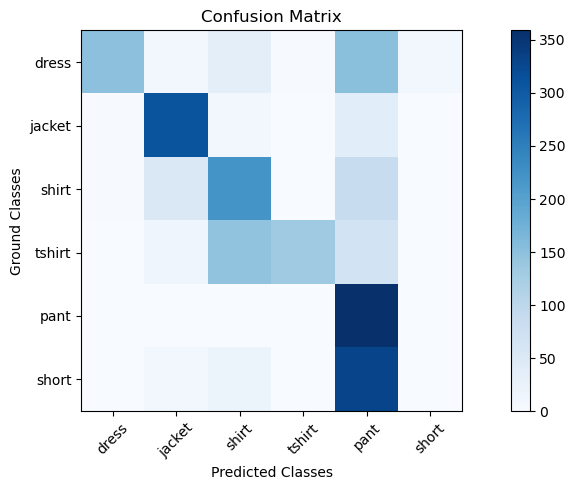

In [99]:
# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 5))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('Ground Classes')
plt.xlabel('Predicted Classes')
plt.tight_layout()
plt.show()